<a href="https://colab.research.google.com/github/YuhaiW/00/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


In [2]:
class Discriminator(nn.Module):
  def __init__(self, im_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(im_dim, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

In [3]:
from torch.nn.modules.activation import Tanh
class Generator(nn.Module):
  def __init__(self, z_dim, im_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,im_dim),
        nn.Tanh()
    )
  
  def forward(self,x):
    return self.gen(x)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [5]:
lr = 9e-4
z_dim = 64
image_dim = 28*28*1
batch_size = 32
num_epochs = 100


In [6]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
fixed_noise.size()

torch.Size([32, 64])

This code block sets up a PyTorch data loader for the MNIST dataset with a specified batch size and data transformations.

Here's what each line does:

transforms.Compose() creates a series of image transformations to be applied to the dataset. In this case, it includes converting the images to PyTorch tensors with transforms.ToTensor(), and then normalizing the tensor values using the mean (0.13,) and standard deviation (0.3,) of the dataset.

datasets.MNIST() initializes a new MNIST dataset instance with the specified root directory for data storage, and the transform parameter to apply the previously created transformations to the dataset. The download parameter is set to True to download the dataset if it doesn't already exist in the specified root directory.

DataLoader() creates a PyTorch data loader for the dataset with the specified batch size batch_size and shuffles the data with shuffle=True during training to avoid bias in the mini-batches.

In [7]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]
)
dataset = datasets.MNIST(root = "dataset/", transform = transforms, download=True)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [8]:
opt_disc = optim.Adam(params = disc.parameters(), lr = lr)
opt_gen = optim.Adam(params = gen.parameters(), lr = lr)
criterion = nn.BCELoss()
writer_FAKE = SummaryWriter(f"/fake")
writer_REAL = SummaryWriter(f"/real")




In [9]:
step = 0
for epoch in range(num_epochs):
  for batch_idX, (real, _) in enumerate(loader):
    real = real.view(-1,784).to(device)
    batch_size = real.shape[0]
    if batch_idX == 0 & epoch == 0:
      print(f"batch_size is{batch_size}!!! ")

    ## Train Discrimiator

    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    #asses real images from the MNIST dataset to the discriminator network disc, 
    #which outputs a probability of the input being a real image.
    #.view(-1) flattens the output tensor to a 1D tensor.
    loss_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).view(-1)
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_avg = (loss_real+loss_fake)/2
    disc.zero_grad()
    loss_avg.backward(retain_graph=True)
    opt_disc.step()

    ## Train Generator
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idX == 0:
      print(
          f"epoch:{epoch}/{num_epochs}"
          f"LossD: {loss_avg: .4f}, LossG:{lossG:.4f}")
      
      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1,1,28,28)
        data = real.reshape(-1,1,28,28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
        img_grid_real = torchvision.utils.make_grid(data, normalize = True)
        

        writer_FAKE.add_image(
            "Minist Fake Image", img_grid_fake, global_step = step

        )
        writer_FAKE.add_image(
            "Minist real Image", img_grid_real, global_step = step
            
        )
        step += 1
      







batch_size is32!!! 
epoch:0/100LossD:  0.8014, LossG:0.7414
batch_size is32!!! 
epoch:1/100LossD:  0.3303, LossG:2.5843
batch_size is32!!! 
epoch:2/100LossD:  0.3413, LossG:2.3502
batch_size is32!!! 
epoch:3/100LossD:  0.6540, LossG:1.8690
batch_size is32!!! 
epoch:4/100LossD:  0.4037, LossG:1.5470
batch_size is32!!! 
epoch:5/100LossD:  0.4849, LossG:2.2271
batch_size is32!!! 
epoch:6/100LossD:  0.6798, LossG:1.3132
batch_size is32!!! 
epoch:7/100LossD:  0.4333, LossG:2.6688
batch_size is32!!! 
epoch:8/100LossD:  0.8135, LossG:1.0501
batch_size is32!!! 
epoch:9/100LossD:  0.9663, LossG:1.0099
batch_size is32!!! 
epoch:10/100LossD:  0.5633, LossG:1.5656
batch_size is32!!! 
epoch:11/100LossD:  0.6095, LossG:1.1583
batch_size is32!!! 
epoch:12/100LossD:  0.6799, LossG:1.1676
batch_size is32!!! 
epoch:13/100LossD:  0.4945, LossG:1.4221
batch_size is32!!! 
epoch:14/100LossD:  0.7499, LossG:1.3081
batch_size is32!!! 
epoch:15/100LossD:  0.5631, LossG:1.2532
batch_size is32!!! 
epoch:16/100Lo

In [10]:
fake = gen(noise)
fake[0].size()


torch.Size([784])

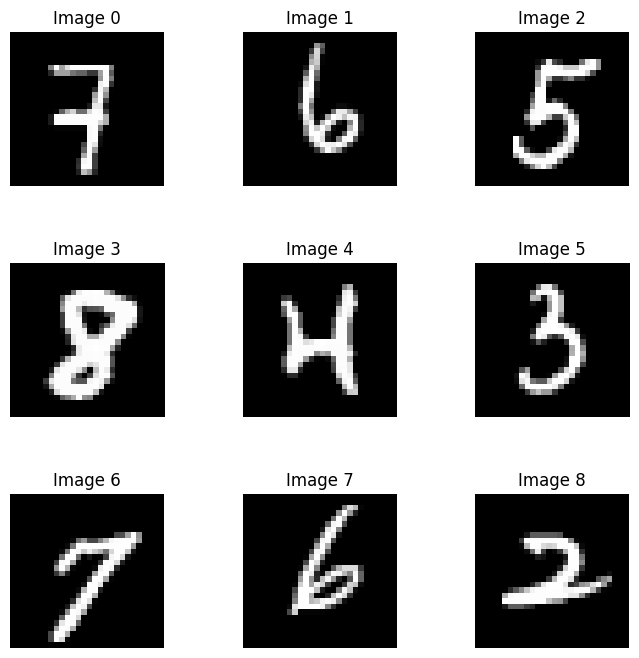

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = real[i].cpu().detach().numpy().reshape(28,28)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()

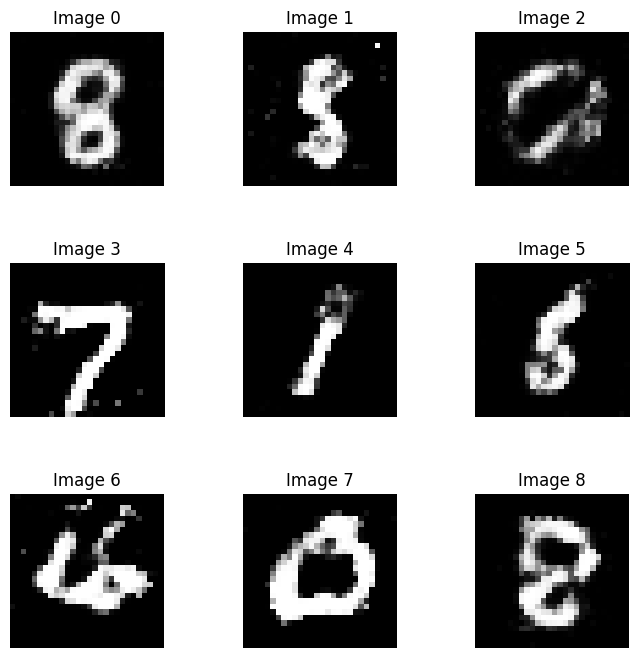

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = fake[i].cpu().detach().numpy().reshape(28,28)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()